# FINM 33150: Quantitative Trading Strategies Homework 2, Simple Spread Trading Simulation
#### Author: Joshua Weekes
#### Due Date: 1/25/2024

#### Sections:

1. Introduction

2. Package Imports

3. Helper Functions

4. Data Import

5. Trading Helper Functions

6. Parameter Initialization

7. Trading Algorithm Logic

8. Running Trading Algortihm on DIfferent Parameter Sets

9. Results

10. Analysis

11. Conclusion

# Introduction

The purpose of this notebook is to get a feel for implementing an algorithmic trading strategy on the spread between the XOP and RSPG ETFs. In this process I will be determining my trading size from the rolling 15 day median of the volume for the less liquid of the two etfs, choosing a total capital that is double the size of the max rolling 15 day median of the less of the two liquid ETFs, determining parameters for when to enter and exit short and long positions on the spread based on the daily change in the spread, accounting for a costless trading opportunity and trading with cost, and setting a value for the difference in the spread to determine that I have hit a stop loss since the spread may not follow the zero reverting property I had expected. I will then show the total capital over time, cumulative profit and loss over the trading period, daily profit and loss over the trading period, and visualizing where I enter and exit my short or long positions or hit a stop loss. For the analysis I will be comparing correlation of the returns of the best 3 trading parameter sets with the returns each of the 3 factors in the fama french three factor model and the returns from the SVol adjusted close and calculating and comparing relavent summary statistics for the same. Finally I will try to make some conclusions on the results and what may be the underlying reasons for these results and give some ways in which this project can be expanded on in the future. 

# Package Imports and API/Date Range Initialization

In [957]:
import os
import pandas as pd
import numpy as np
import quandl
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns
import statsmodels.api as sm
from datetime import date
import datetime
import functools

global api_key
api_key = 'ykKjRrdMDZk8sVyrhPEV'
start_date = '2021-12-2'
end_date = '2023-11-15'

# Helper Functions

In [958]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r'C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data', 'quandl_data_table_downloads')
    data_symlink = os.path.join(root_data_dir, f"{table_path}.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"

def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

# Importing Data

In [959]:
etf_df = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=True, ticker=['RSPG', 'XOP', 'SVOL'], date={'gte': start_date, 'lte': end_date})
# etf_df.head()

Data file C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240125.zip size 55248 exists already, no need to download


In [960]:
ff_factors = pd.read_csv(r'data\Developed_3_Factors_Daily.csv', index_col=0, parse_dates=True)
ff_factors = ff_factors.loc[start_date:end_date]
# ff_factors.head()

In [961]:
svol_df = etf_df.loc[etf_df['ticker'] == 'SVOL'].set_index(['date'])
# svol_df.head()

In [962]:
xop_df = etf_df.loc[etf_df['ticker'] == 'XOP'].set_index(['date'])
# xop_df.head()

In [963]:
rspg_df = etf_df.loc[etf_df['ticker'] == 'RSPG'].set_index(['date'])
# rspg_df.head()

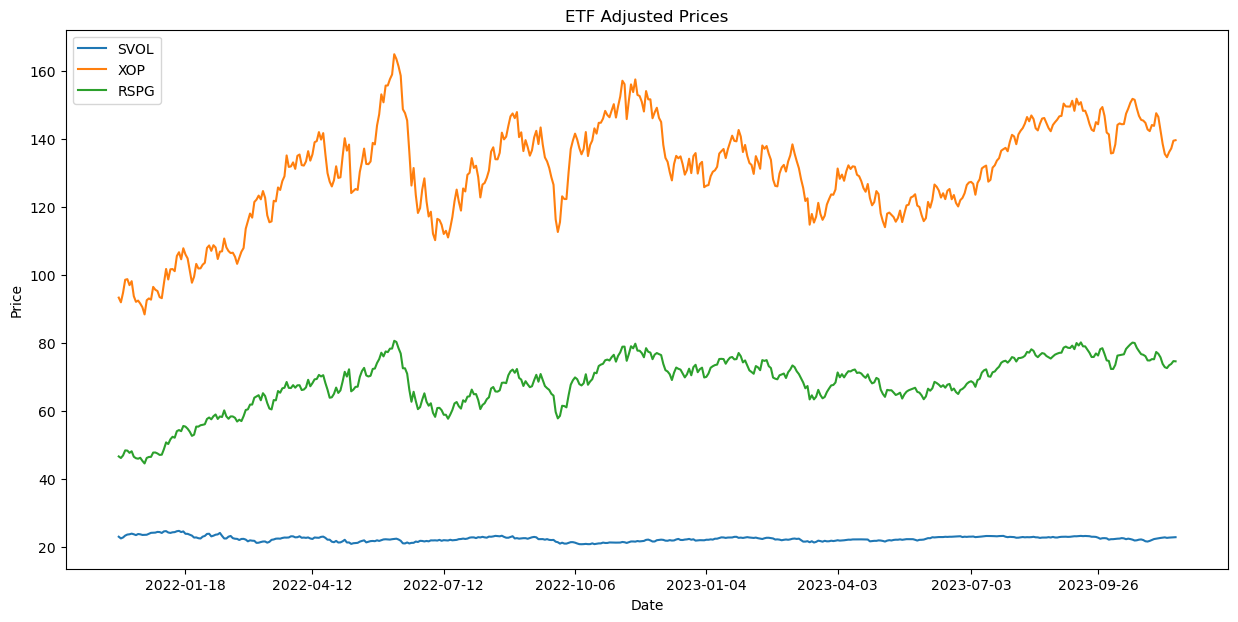

In [964]:
plt.figure(figsize=(15, 7))
plt.plot(svol_df['adj_close'], label='SVOL')
plt.plot(xop_df['adj_close'], label='XOP')
plt.plot(rspg_df['adj_close'], label='RSPG')
plt.title('ETF Adjusted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()
plt.show()


In [965]:
spread_df = xop_df[['adj_close']] - rspg_df[['adj_close']]
spread_df.columns = ['ETF Spread']
# spread_df.head()

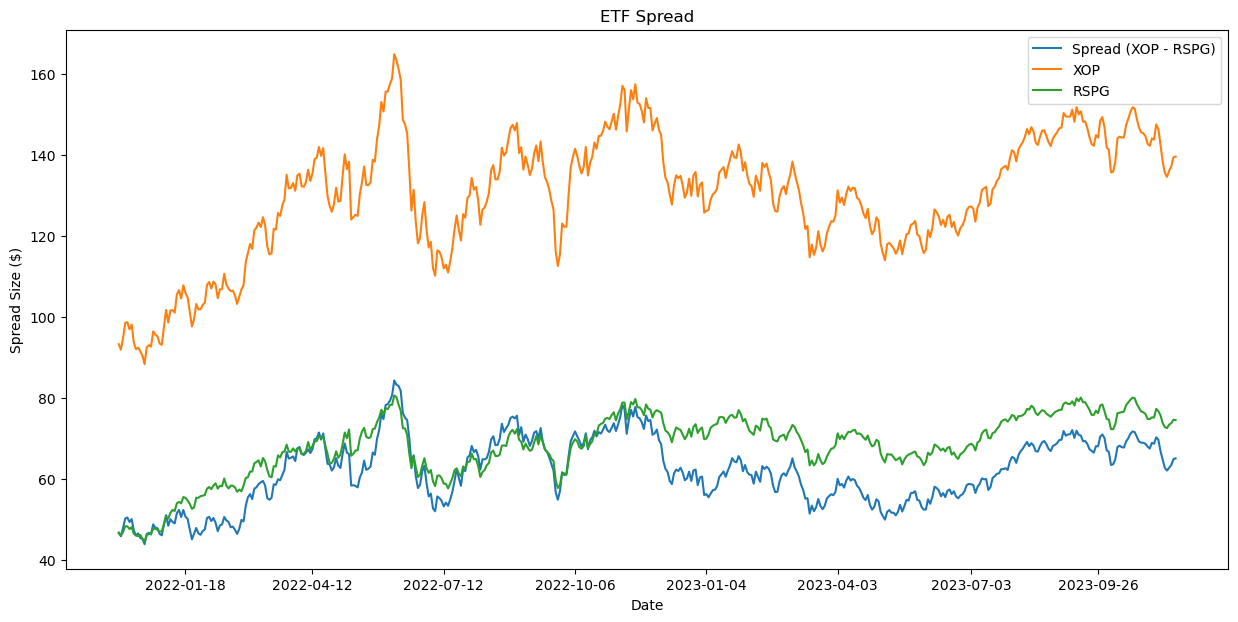

In [966]:
plt.figure(figsize=(15, 7))
plt.plot(spread_df, label='Spread (XOP - RSPG)')
plt.plot(xop_df['adj_close'], label='XOP')
plt.plot(rspg_df['adj_close'], label='RSPG')
plt.title('ETF Spread')
plt.xlabel('Date')
plt.ylabel('Spread Size ($)')
# change the x axis to display every 4th month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()
plt.show()

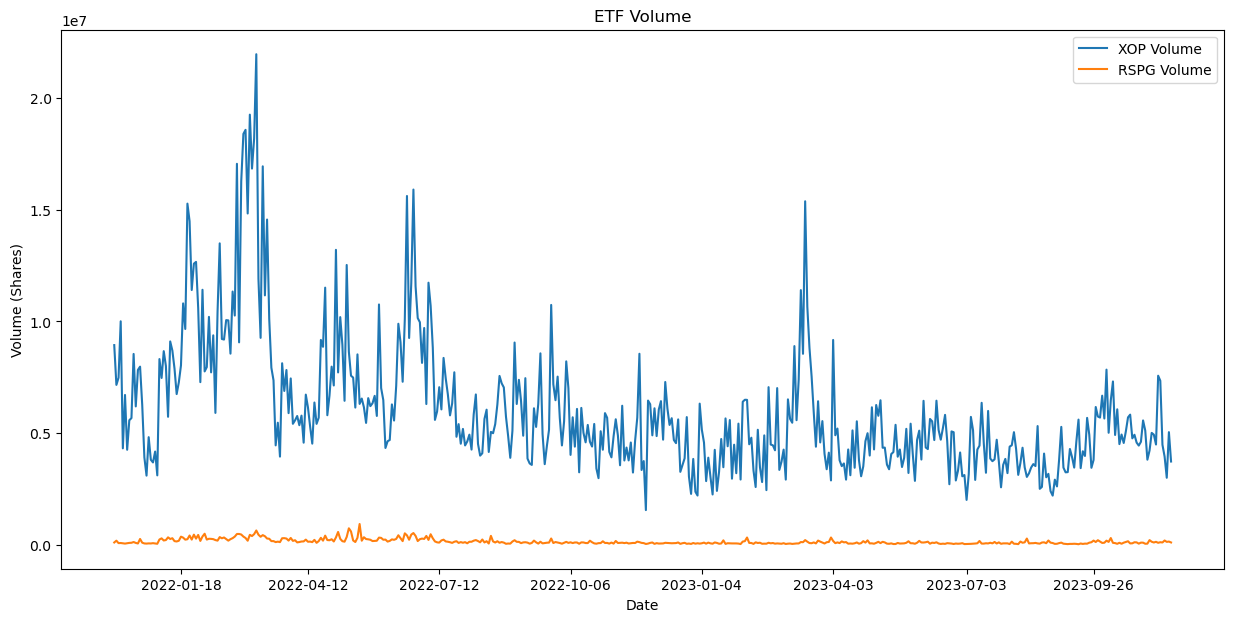

In [967]:
plt.figure(figsize=(15, 7))
plt.plot(xop_df['adj_volume'], label='XOP Volume')
plt.plot(rspg_df['adj_volume'], label='RSPG Volume')
plt.title('ETF Volume')
plt.xlabel('Date')
plt.ylabel('Volume (Shares)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()
plt.show()

Clearly RSPG has the lowest volume over the time horizon.

In [968]:
spread_df['Dollar Volume'] = rspg_df['adj_volume'] * rspg_df['adj_close']
spread_df['Rolling Median Dollar Volume'] = spread_df['Dollar Volume'].rolling(15).median()
# spread_df.iloc[13:19, :]

In [969]:
trade_df = pd.DataFrame()
trade_df.index = spread_df.index
trade_df['XOP Share Price'] = xop_df['adj_close']
trade_df['RSPG Share Price'] = rspg_df['adj_close']
trade_df['Change in Spread'] = spread_df['ETF Spread'].diff()
trade_df['Open Position Size'] = spread_df['Rolling Median Dollar Volume'] / 100
trade_df['Stop Loss Hit Bool'] = [False] * len(spread_df)
trade_df['Day Trade Action'] = ['none'] * len(spread_df)
trade_df['Outstanding XOP Shares'] = [0] * len(spread_df)
trade_df['Outstanding RSPG Shares'] = [0] * len(spread_df)
trade_df['Non Working Capital (Costless)'] = [0] * len(spread_df)
trade_df['Non Working Capital (With Cost)'] = [0] * len(spread_df)
trade_df['Total Capital (Costless)'] = [0] * len(spread_df)
trade_df['Total Capital (With Cost)'] = [0] * len(spread_df)
# trade_df.iloc[13:19, :]


In [970]:
# find double the max absolute value of the change in spread
abs_stop_loss = 2*trade_df['Change in Spread'].loc[:'2022'].abs().max()

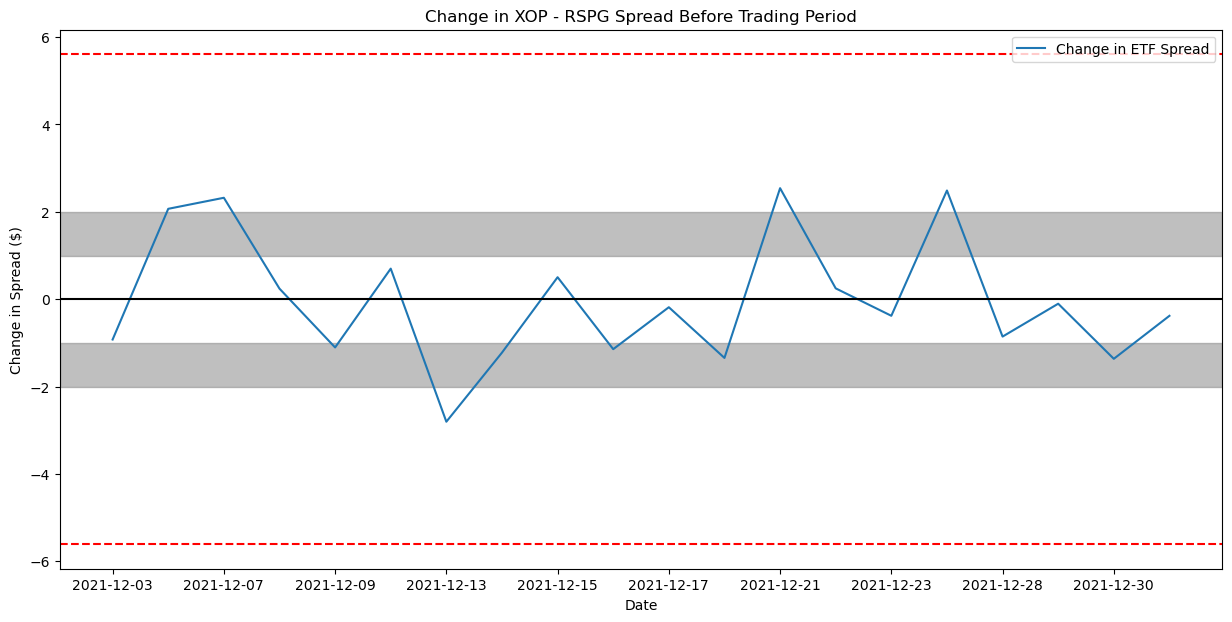

In [971]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df[['Change in Spread']].loc[:'2022'], label='Change in ETF Spread')
plt.title('Change in XOP - RSPG Spread Before Trading Period')
plt.xlabel('Date')
plt.ylabel('Change in Spread ($)')
# change the x axis to display every other day
plt.gca().xaxis.set_major_locator(dates.DayLocator(interval=2))
# add a black horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-')
# add a red dotted horizontal line for the stop loss
plt.axhline(y=abs_stop_loss, color='red', linestyle='--')
plt.axhline(y=-abs_stop_loss, color='red', linestyle='--')
# add a shaded region between y = .5 and y = 2
plt.axhspan(1, 2, alpha=0.5, color='grey')
plt.axhspan(-1, -2, alpha=0.5, color='grey')
plt.legend()
plt.show()

# Trading Helper Functions

In [972]:
def open_position(df, date, short: bool, current_position, trade_signals):
    if short:
        xop_share_count = -int(df['Open Position Size'].loc[date] // df['XOP Share Price'].loc[date])
        rspg_share_count = int(df['Open Position Size'].loc[date] // df['RSPG Share Price'].loc[date])
        current_position['Side'] = 'short'
        current_position['XOP Shares'] = xop_share_count
        current_position['RSPG Shares'] = rspg_share_count
    elif not short:
        xop_share_count = int(df['Open Position Size'].loc[date] // df['XOP Share Price'].loc[date])
        rspg_share_count = -int(df['Open Position Size'].loc[date] // df['RSPG Share Price'].loc[date])
        current_position['Side'] = 'long'
        current_position['XOP Shares'] = xop_share_count
        current_position['RSPG Shares'] = rspg_share_count

    current_position['XOP Entry Share Price'] = df['XOP Share Price'].loc[date]
    current_position['RSPG Entry Share Price'] = df['RSPG Share Price'].loc[date]
    current_position['Non Working Capital (Costless)'] = current_position['Total Capital (Costless)'] - (current_position['XOP Shares'] * df['XOP Share Price'].loc[date] + current_position['RSPG Shares'] * df['RSPG Share Price'].loc[date])
    current_position['Non Working Capital (With Cost)'] = current_position['Total Capital (With Cost)'] - (current_position['XOP Shares'] * df['XOP Share Price'].loc[date] + current_position['RSPG Shares'] * df['RSPG Share Price'].loc[date]) - (current_position['XOP Shares'] * df['XOP Share Price'].loc[date] * trade_signals['trade cost'] + current_position['RSPG Shares'] * df['RSPG Share Price'].loc[date] * trade_signals['trade cost'])

    df.loc[date, 'Outstanding XOP Shares'] = current_position['XOP Shares']
    df.loc[date, 'Outstanding RSPG Shares'] = current_position['RSPG Shares']
    df.loc[date, 'Non Working Capital (Costless)'] = current_position['Non Working Capital (Costless)']
    df.loc[date, 'Total Capital (Costless)'] = current_position['Total Capital (Costless)']
    df.loc[date, 'Non Working Capital (With Cost)'] = current_position['Non Working Capital (With Cost)']
    df.loc[date, 'Total Capital (With Cost)'] = current_position['Total Capital (With Cost)']

    return current_position, df

In [973]:
def close_position(current_position, trade_signals, df, date):
    current_position['Side'] = 'none'
    current_position['Non Working Capital (Costless)'] = current_position['Total Capital (With Cost)'] - (current_position['XOP Shares'] * df['XOP Share Price'].loc[date] * trade_signals['trade cost'] + current_position['RSPG Shares'] * df['RSPG Share Price'].loc[date] * trade_signals['trade cost'])
    current_position['XOP Shares'] = 0
    current_position['RSPG Shares'] = 0
    current_position['Non Working Capital (Costless)'] = current_position['Total Capital (Costless)']

    return current_position

In [974]:
def open_position_check(df, date, current_position, trade_signals):
    if df['Change in Spread'].loc[date] > trade_signals['Open Short']:
        current_position, df = open_position(df, date, True, current_position, trade_signals)
    elif df['Change in Spread'].loc[date] < trade_signals['Open Long']:
        current_position, df = open_position(df, date, False, current_position, trade_signals)

    return current_position, df

In [975]:
def close_position_check(df, date, current_position, trade_signals):
    if current_position['Side'] == 'short':
        if df['Change in Spread'].loc[date] < trade_signals['Close Short']:
            return True
    elif current_position['Side'] == 'long':
        if df['Change in Spread'].loc[date] > trade_signals['Close Long']:
            return True  
    else:
        return False

In [976]:
def stop_loss_check(df, date, current_position, trade_signals):
    if current_position['Side'] == 'short' and df['Change in Spread'].loc[date] > trade_signals['Stop Loss']:
        return True
    elif current_position['Side'] == 'long' and df['Change in Spread'].loc[date] < -trade_signals['Stop Loss']:
        return True
    elif current_position['Side'] == 'none' and (df['Change in Spread'].loc[date] > trade_signals['Stop Loss'] or df['Change in Spread'].loc[date] < -trade_signals['Stop Loss']):
        return True
    else:
        return False

In [977]:
def update_capital(df, date, current_position):
    xop_price_change = df['XOP Share Price'].loc[date] - current_position['XOP Entry Share Price']
    rspg_price_change = df['RSPG Share Price'].loc[date] - current_position['RSPG Entry Share Price']

    xop_position_change = current_position['XOP Shares'] * xop_price_change
    rspg_position_change = current_position['RSPG Shares'] * rspg_price_change

    entry_capital = current_position['XOP Shares'] * current_position['XOP Entry Share Price'] + current_position['RSPG Shares'] * current_position['RSPG Entry Share Price']
    
    current_position['Total Capital (Costless)'] = current_position['Non Working Capital (Costless)'] + entry_capital + xop_position_change + rspg_position_change
    current_position['Total Capital (With Cost)'] = current_position['Non Working Capital (With Cost)'] + entry_capital + xop_position_change + rspg_position_change


    df.loc[date, 'Total Capital (Costless)'] = current_position['Total Capital (Costless)']
    df.loc[date, 'Non Working Capital (Costless)'] = current_position['Non Working Capital (Costless)']

    df.loc[date, 'Total Capital (With Cost)'] = current_position['Total Capital (With Cost)']
    df.loc[date, 'Non Working Capital (With Cost)'] = current_position['Non Working Capital (With Cost)']
    
    df.loc[date, 'Outstanding XOP Shares'] = current_position['XOP Shares']
    df.loc[date, 'Outstanding RSPG Shares']= current_position['RSPG Shares']
    return current_position, df

# Initializing Trading Paramenters

In [978]:
starting_capital = 2*spread_df['Rolling Median Dollar Volume'].max()
current_position = {'Side':'none', 'XOP Shares': 0, 'RSPG Shares': 0, 'XOP Entry Share Price': 0, 'RSPG Entry Share Price': 0, 'Total Capital (Costless)': starting_capital, 'Non Working Capital (Costless)': starting_capital, 'Total Capital (With Cost)': starting_capital, 'Non Working Capital (With Cost)': starting_capital}
trade_signals_1 = {'Open Short': 2, 'Close Short': 1, 'Open Long': -2, 'Close Long': -1, 'Stop Loss': abs_stop_loss, 'trade cost': 0.0001}

In [979]:
trade_signals_2 = {'Open Short': 2, 'Close Short': 0.5, 'Open Long': -2, 'Close Long': -0.5, 'Stop Loss': abs_stop_loss, 'trade cost': 0.0001}
trade_signals_3 = {'Open Short': 3, 'Close Short': 1, 'Open Long': -3, 'Close Long': -1, 'Stop Loss': abs_stop_loss, 'trade cost': 0.0001}
trade_signals_4 = {'Open Short': 3, 'Close Short': 0.5, 'Open Long': -3, 'Close Long': -0.5, 'Stop Loss': abs_stop_loss, 'trade cost': 0.0001}

In [980]:
trade_df_1 = trade_df.loc['2022':].copy()
trade_df_2 = trade_df.loc['2022':].copy()
trade_df_3 = trade_df.loc['2022':].copy()
trade_df_4 = trade_df.loc['2022':].copy()

# Trading Algorithm Logic

In [981]:
def trading_logic(trade_df_in_period, date, current_position, trade_signals):
    for date in trade_df_in_period.index:
        if not trade_df_in_period.loc[date, 'Stop Loss Hit Bool']:
            if current_position['Side'] == 'none' and not stop_loss_check(trade_df_in_period, date, current_position, trade_signals):
                current_position, trade_df_in_period = open_position_check(trade_df_in_period, date, current_position, trade_signals)
                if current_position['Side'] != 'none':
                    trade_df_in_period.loc[date, 'Day Trade Action'] = 'open'
            elif current_position['Side'] != 'none' and close_position_check(trade_df_in_period, date, current_position, trade_signals):
                current_position, trade_df_in_period = update_capital(trade_df_in_period, date, current_position)
                current_position = close_position(current_position, trade_signals, trade_df_in_period, date)
                # current_position, trade_df = update_capital(trade_df, date, current_position)
                current_position, trade_df_in_period = open_position_check(trade_df_in_period, date, current_position, trade_signals)
                if current_position['Side'] != 'none':
                    trade_df_in_period.loc[date, 'Day Trade Action'] = 'close and open'
                else:
                    trade_df_in_period.loc[date, 'Day Trade Action'] = 'close'
            elif current_position['Side'] != 'none' and stop_loss_check(trade_df_in_period, date, current_position, trade_signals):
                current_position, trade_df_in_period = update_capital(trade_df_in_period, date, current_position)
                current_position = close_position(current_position, trade_signals, trade_df_in_period, date)
                current_position, trade_df_in_period = update_capital(trade_df_in_period, date, current_position)
                trade_df_in_period.loc[date, 'Day Trade Action'] = 'stop loss hit'
                trade_df_in_period.loc[date, 'Stop Loss Hit Bool'] = True
                start_of_next_month = (date[:5] + str(int(date[5:7]) + 1)) if (int(date[5:7]) + 1 > 10) else (date[:5] + '0' + str(int(date[5:7]) + 1))
                trade_df_in_period.loc[date: start_of_next_month, 'Stop Loss Hit Bool'] = True
            
                
        current_position, trade_df_in_period = update_capital(trade_df_in_period, date, current_position)

    current_position = close_position(current_position, trade_signals, trade_df_in_period, date)
    current_position, trade_df_in_period = update_capital(trade_df_in_period, date, current_position)

    return trade_df_in_period

# Running Trading Algorithm for Different Parameter Sets

In [982]:
trade_df_1 = trading_logic(trade_df_1, date, current_position, trade_signals_1)
current_position = {'Side':'none', 'XOP Shares': 0, 'RSPG Shares': 0, 'XOP Entry Share Price': 0, 'RSPG Entry Share Price': 0, 'Total Capital (Costless)': starting_capital, 'Non Working Capital (Costless)': starting_capital, 'Total Capital (With Cost)': starting_capital, 'Non Working Capital (With Cost)': starting_capital}
trade_df_2 = trading_logic(trade_df_2, date, current_position, trade_signals_2)
current_position = {'Side':'none', 'XOP Shares': 0, 'RSPG Shares': 0, 'XOP Entry Share Price': 0, 'RSPG Entry Share Price': 0, 'Total Capital (Costless)': starting_capital, 'Non Working Capital (Costless)': starting_capital, 'Total Capital (With Cost)': starting_capital, 'Non Working Capital (With Cost)': starting_capital}
trade_df_3 = trading_logic(trade_df_3, date, current_position, trade_signals_3)
current_position = {'Side':'none', 'XOP Shares': 0, 'RSPG Shares': 0, 'XOP Entry Share Price': 0, 'RSPG Entry Share Price': 0, 'Total Capital (Costless)': starting_capital, 'Non Working Capital (Costless)': starting_capital, 'Total Capital (With Cost)': starting_capital, 'Non Working Capital (With Cost)': starting_capital}
trade_df_4 = trading_logic(trade_df_4, date, current_position, trade_signals_4)

C:\Users\joshw\AppData\Local\Temp\ipykernel_18044\2077255789.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53307465.96285704' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[date, 'Non Working Capital (Costless)'] = current_position['Non Working Capital (Costless)']
C:\Users\joshw\AppData\Local\Temp\ipykernel_18044\2077255789.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53307475.26626654' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[date, 'Total Capital (Costless)'] = current_position['Total Capital (Costless)']
C:\Users\joshw\AppData\Local\Temp\ipykernel_18044\2077255789.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53307465.9619267' has dtype incompatib

C:\Users\joshw\AppData\Local\Temp\ipykernel_18044\244763369.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53307475.26626654' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[date, 'Total Capital (Costless)'] = current_position['Total Capital (Costless)']
C:\Users\joshw\AppData\Local\Temp\ipykernel_18044\244763369.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53307475.26626654' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[date, 'Non Working Capital (Costless)'] = current_position['Non Working Capital (Costless)']
C:\Users\joshw\AppData\Local\Temp\ipykernel_18044\244763369.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '53307475.26626654' has dtype incompatible

# Results

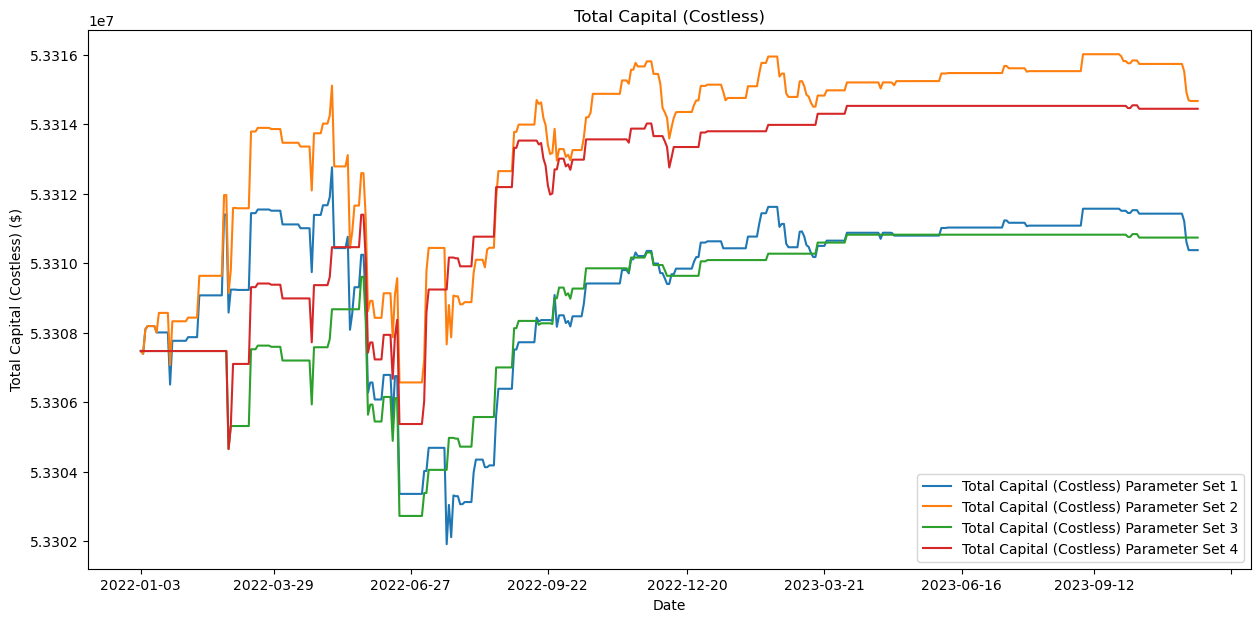

In [983]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df_1[['Total Capital (Costless)']], label='Total Capital (Costless) Parameter Set 1')
plt.plot(trade_df_2[['Total Capital (Costless)']], label='Total Capital (Costless) Parameter Set 2')
plt.plot(trade_df_3[['Total Capital (Costless)']], label='Total Capital (Costless) Parameter Set 3')
plt.plot(trade_df_4[['Total Capital (Costless)']], label='Total Capital (Costless) Parameter Set 4')
plt.title('Total Capital (Costless)')
plt.xlabel('Date')
plt.ylabel('Total Capital (Costless) ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()
plt.show()

In [984]:
# trade_df_3.head()

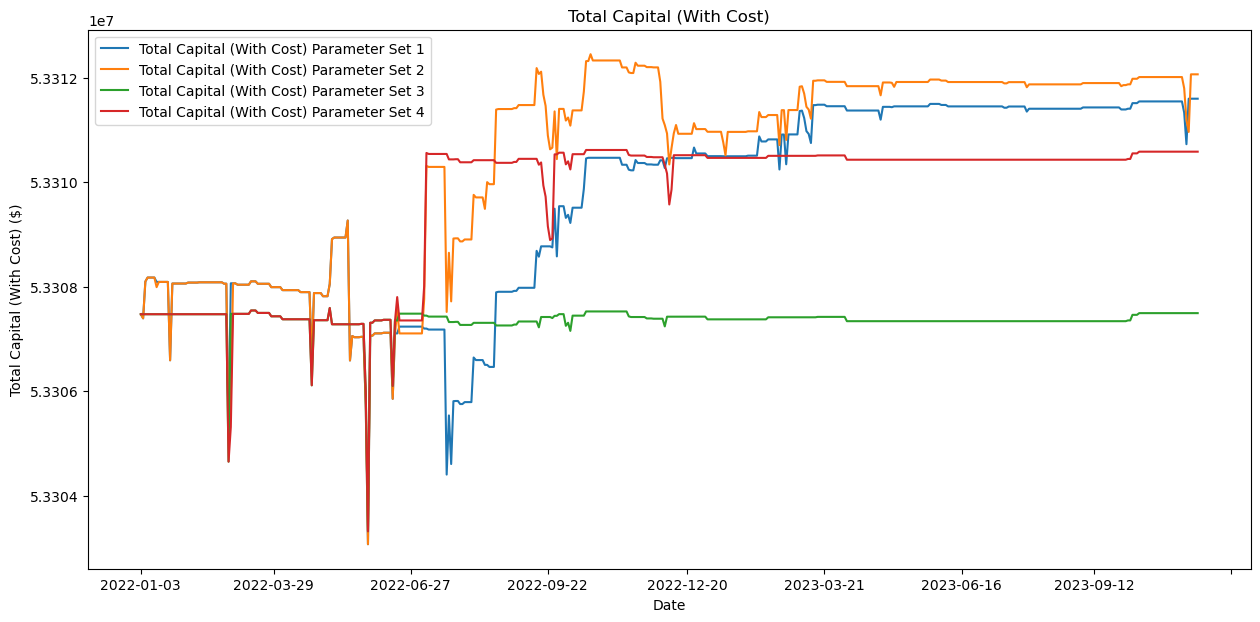

In [985]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df_1[['Total Capital (With Cost)']], label='Total Capital (With Cost) Parameter Set 1')
plt.plot(trade_df_2[['Total Capital (With Cost)']], label='Total Capital (With Cost) Parameter Set 2')
plt.plot(trade_df_3[['Total Capital (With Cost)']], label='Total Capital (With Cost) Parameter Set 3')
plt.plot(trade_df_4[['Total Capital (With Cost)']], label='Total Capital (With Cost) Parameter Set 4')
plt.title('Total Capital (With Cost)')
plt.xlabel('Date')
plt.ylabel('Total Capital (With Cost) ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()
plt.show()

In [986]:
def calculate_pnl(trade_df_in_period):
    trade_df_in_period.loc[:, 'Day PnL (Costless)'] = trade_df_in_period['Total Capital (Costless)'].diff()
    trade_df_in_period.loc[:, 'Day PnL (With Cost)'] = trade_df_in_period['Total Capital (With Cost)'].diff()
    trade_df_in_period.loc[:, 'Cumulative PnL'] = trade_df_in_period['Day PnL (Costless)'].cumsum()
    trade_df_in_period.loc[:, 'Cumulative PnL (With Cost)'] = trade_df_in_period['Day PnL (With Cost)'].cumsum()
    return trade_df_in_period

In [987]:
trade_df_1 = calculate_pnl(trade_df_1)
trade_df_2 = calculate_pnl(trade_df_2)
trade_df_3 = calculate_pnl(trade_df_3)
trade_df_4 = calculate_pnl(trade_df_4)

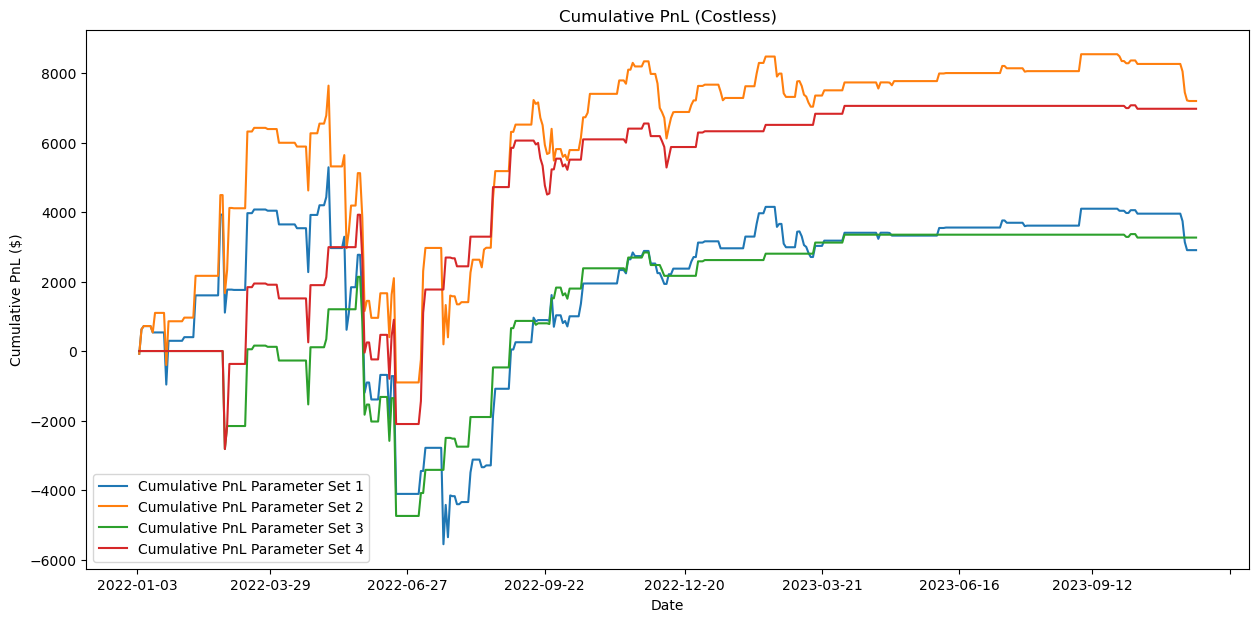

In [988]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df_1[['Cumulative PnL']], label='Cumulative PnL Parameter Set 1')
plt.plot(trade_df_2[['Cumulative PnL']], label='Cumulative PnL Parameter Set 2')
plt.plot(trade_df_3[['Cumulative PnL']], label='Cumulative PnL Parameter Set 3')
plt.plot(trade_df_4[['Cumulative PnL']], label='Cumulative PnL Parameter Set 4')
plt.title('Cumulative PnL (Costless)')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()

plt.show()

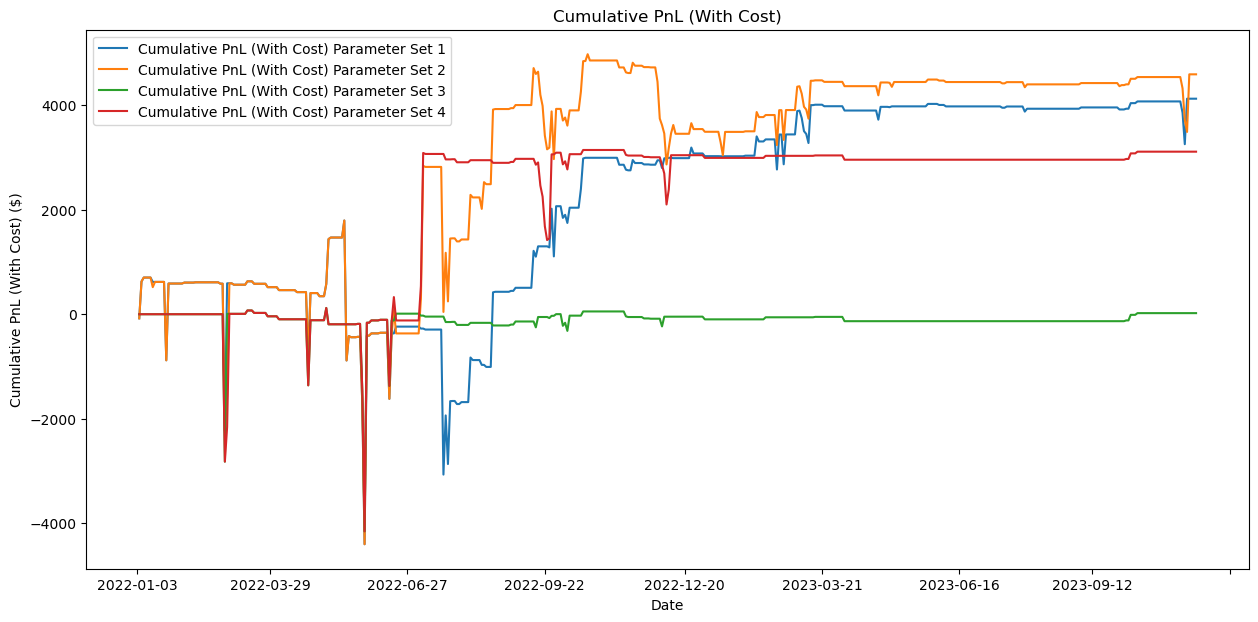

In [989]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df_1[['Cumulative PnL (With Cost)']], label='Cumulative PnL (With Cost) Parameter Set 1')
plt.plot(trade_df_2[['Cumulative PnL (With Cost)']], label='Cumulative PnL (With Cost) Parameter Set 2')
plt.plot(trade_df_3[['Cumulative PnL (With Cost)']], label='Cumulative PnL (With Cost) Parameter Set 3')
plt.plot(trade_df_4[['Cumulative PnL (With Cost)']], label='Cumulative PnL (With Cost) Parameter Set 4')
plt.title('Cumulative PnL (With Cost)')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (With Cost) ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
plt.legend()

plt.show()

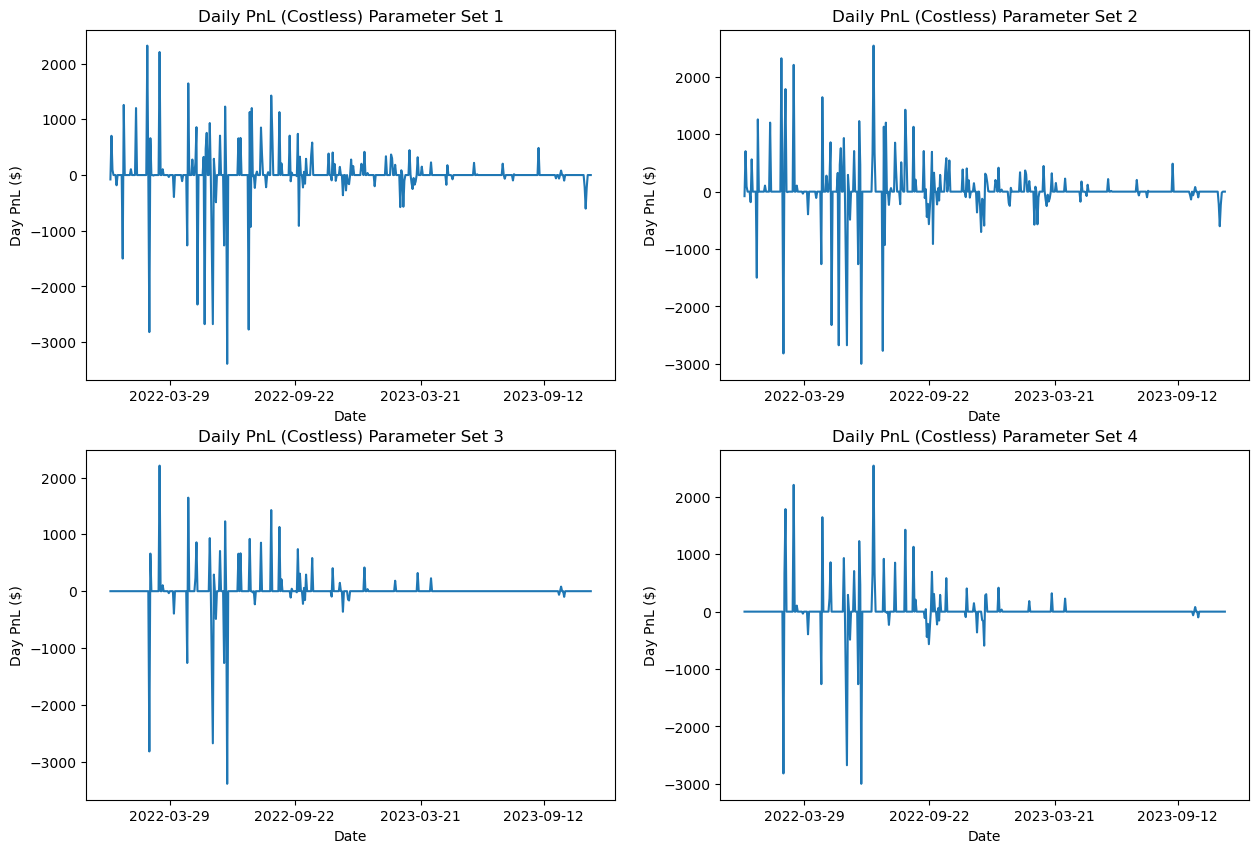

In [990]:
figure, axis = plt.subplots(2, 2)
figure.set_figheight(10)
figure.set_figwidth(15)

axis[0, 0].plot(trade_df_1[['Day PnL (Costless)']], label='Day PnL (Costless) Parameter Set 1')
axis[0, 0].set_title('Daily PnL (Costless) Parameter Set 1')
axis[0, 0].set_xlabel('Date')
axis[0, 0].set_ylabel('Day PnL ($)')
axis[0, 0].xaxis.set_major_locator(dates.MonthLocator(interval=4))

axis[0, 1].plot(trade_df_2[['Day PnL (Costless)']], label='Day PnL (Costless) Parameter Set 2')
axis[0, 1].set_title('Daily PnL (Costless) Parameter Set 2')
axis[0, 1].set_xlabel('Date')
axis[0, 1].set_ylabel('Day PnL ($)')
axis[0, 1].xaxis.set_major_locator(dates.MonthLocator(interval=4))

axis[1, 0].plot(trade_df_3[['Day PnL (Costless)']], label='Day PnL (Costless) Parameter Set 3')
axis[1, 0].set_title('Daily PnL (Costless) Parameter Set 3')
axis[1, 0].set_xlabel('Date')
axis[1, 0].set_ylabel('Day PnL ($)')
axis[1, 0].xaxis.set_major_locator(dates.MonthLocator(interval=4))

axis[1, 1].plot(trade_df_4[['Day PnL (Costless)']], label='Day PnL (Costless) Parameter Set 4')
axis[1, 1].set_title('Daily PnL (Costless) Parameter Set 4')
axis[1, 1].set_xlabel('Date')
axis[1, 1].set_ylabel('Day PnL ($)')
axis[1, 1].xaxis.set_major_locator(dates.MonthLocator(interval=4))
plt.show()

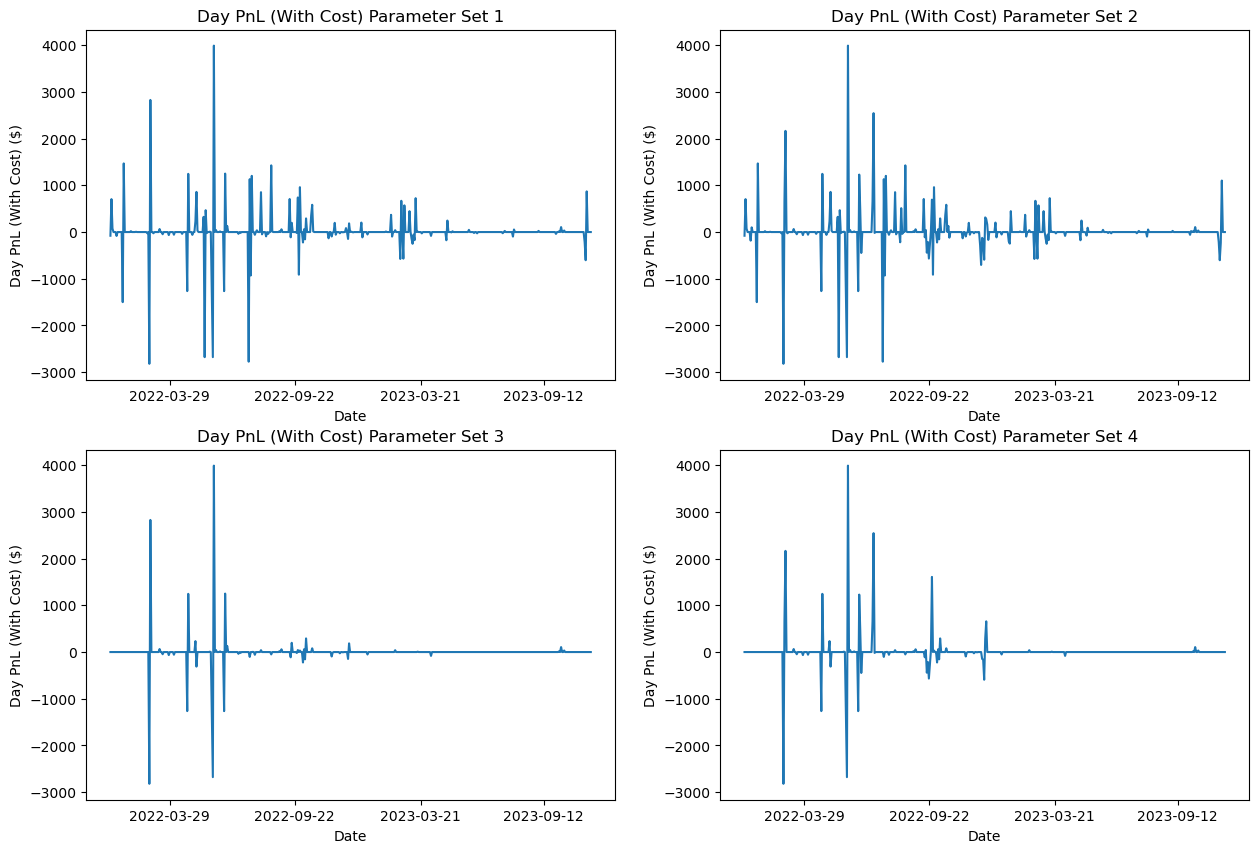

In [991]:
figure, axis = plt.subplots(2, 2)
figure.set_figheight(10)
figure.set_figwidth(15)

axis[0, 0].plot(trade_df_1[['Day PnL (With Cost)']], label='Day PnL (With Cost) Parameter Set 1')
axis[0, 0].set_title('Day PnL (With Cost) Parameter Set 1')
axis[0, 0].set_xlabel('Date')
axis[0, 0].set_ylabel('Day PnL (With Cost) ($)')
axis[0, 0].xaxis.set_major_locator(dates.MonthLocator(interval=4))

axis[0, 1].plot(trade_df_2[['Day PnL (With Cost)']], label='Day PnL (With Cost) Parameter Set 2')
axis[0, 1].set_title('Day PnL (With Cost) Parameter Set 2')
axis[0, 1].set_xlabel('Date')
axis[0, 1].set_ylabel('Day PnL (With Cost) ($)')
axis[0, 1].xaxis.set_major_locator(dates.MonthLocator(interval=4))

axis[1, 0].plot(trade_df_3[['Day PnL (With Cost)']], label='Day PnL (With Cost) Parameter Set 3')
axis[1, 0].set_title('Day PnL (With Cost) Parameter Set 3')
axis[1, 0].set_xlabel('Date')
axis[1, 0].set_ylabel('Day PnL (With Cost) ($)')
axis[1, 0].xaxis.set_major_locator(dates.MonthLocator(interval=4))

axis[1, 1].plot(trade_df_4[['Day PnL (With Cost)']], label='Day PnL (With Cost) Parameter Set 4')
axis[1, 1].set_title('Day PnL (With Cost) Parameter Set 4')
axis[1, 1].set_xlabel('Date')
axis[1, 1].set_ylabel('Day PnL (With Cost) ($)')
axis[1, 1].xaxis.set_major_locator(dates.MonthLocator(interval=4))

plt.show()

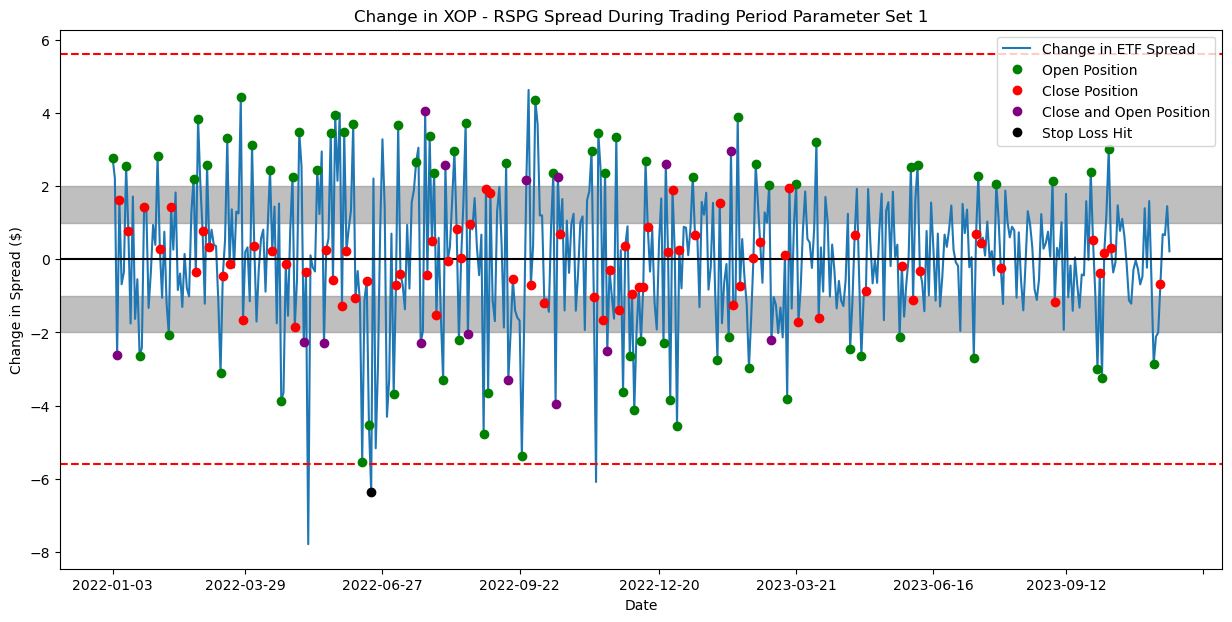

In [992]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df[['Change in Spread']].loc['2022':], label='Change in ETF Spread')
plt.title('Change in XOP - RSPG Spread During Trading Period Parameter Set 1')
plt.xlabel('Date')
plt.ylabel('Change in Spread ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
# add a black horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-')
# add a red dotted horizontal line for the stop loss
plt.axhline(y=abs_stop_loss, color='red', linestyle='--')
plt.axhline(y=-abs_stop_loss, color='red', linestyle='--')
# add a shaded region between y = .5 and y = 2
plt.axhspan(1, 2, alpha=0.5, color='grey')
plt.axhspan(-1, -2, alpha=0.5, color='grey')

plt.plot(trade_df_1['Change in Spread'].loc[trade_df_1['Day Trade Action'] == 'open'], color='green', marker='o', linestyle = 'none', label='Open Position')
plt.plot(trade_df_1['Change in Spread'].loc[trade_df_1['Day Trade Action'] == 'close'], color='red', marker='o', linestyle = 'none', label='Close Position')
plt.plot(trade_df_1['Change in Spread'].loc[trade_df_1['Day Trade Action'] == 'close and open'], color='purple', marker='o', linestyle = 'none', label='Close and Open Position')
plt.plot(trade_df_1['Change in Spread'].loc[trade_df_1['Day Trade Action'] == 'stop loss hit'], color='black', marker='o', linestyle = 'none', label='Stop Loss Hit')

plt.legend()
plt.show()

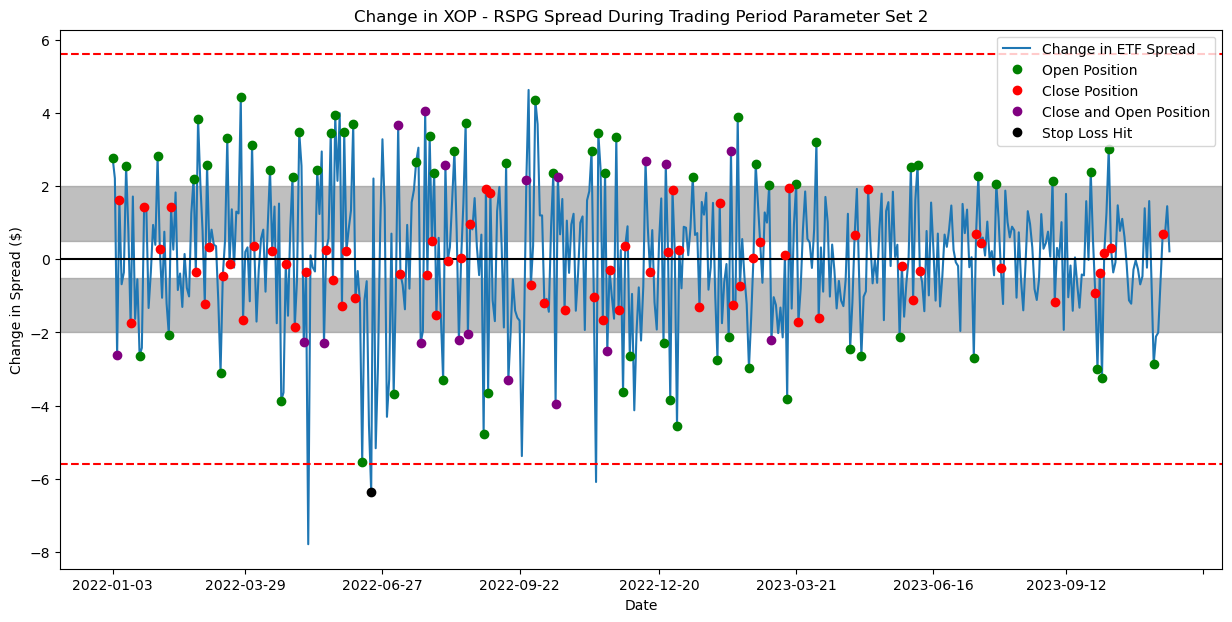

In [993]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df[['Change in Spread']].loc['2022':], label='Change in ETF Spread')
plt.title('Change in XOP - RSPG Spread During Trading Period Parameter Set 2')
plt.xlabel('Date')
plt.ylabel('Change in Spread ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
# add a black horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-')
# add a red dotted horizontal line for the stop loss
plt.axhline(y=abs_stop_loss, color='red', linestyle='--')
plt.axhline(y=-abs_stop_loss, color='red', linestyle='--')
# add a shaded region between y = .5 and y = 2
plt.axhspan(trade_signals_2['Close Short'], trade_signals_2['Open Short'], alpha=0.5, color='grey')
plt.axhspan(trade_signals_2['Close Long'], trade_signals_2['Open Long'], alpha=0.5, color='grey')

plt.plot(trade_df_2['Change in Spread'].loc[trade_df_2['Day Trade Action'] == 'open'], color='green', marker='o', linestyle = 'none', label='Open Position')
plt.plot(trade_df_2['Change in Spread'].loc[trade_df_2['Day Trade Action'] == 'close'], color='red', marker='o', linestyle = 'none', label='Close Position')
plt.plot(trade_df_2['Change in Spread'].loc[trade_df_2['Day Trade Action'] == 'close and open'], color='purple', marker='o', linestyle = 'none', label='Close and Open Position')
plt.plot(trade_df_2['Change in Spread'].loc[trade_df_2['Day Trade Action'] == 'stop loss hit'], color='black', marker='o', linestyle = 'none', label='Stop Loss Hit')

plt.legend()
plt.show()

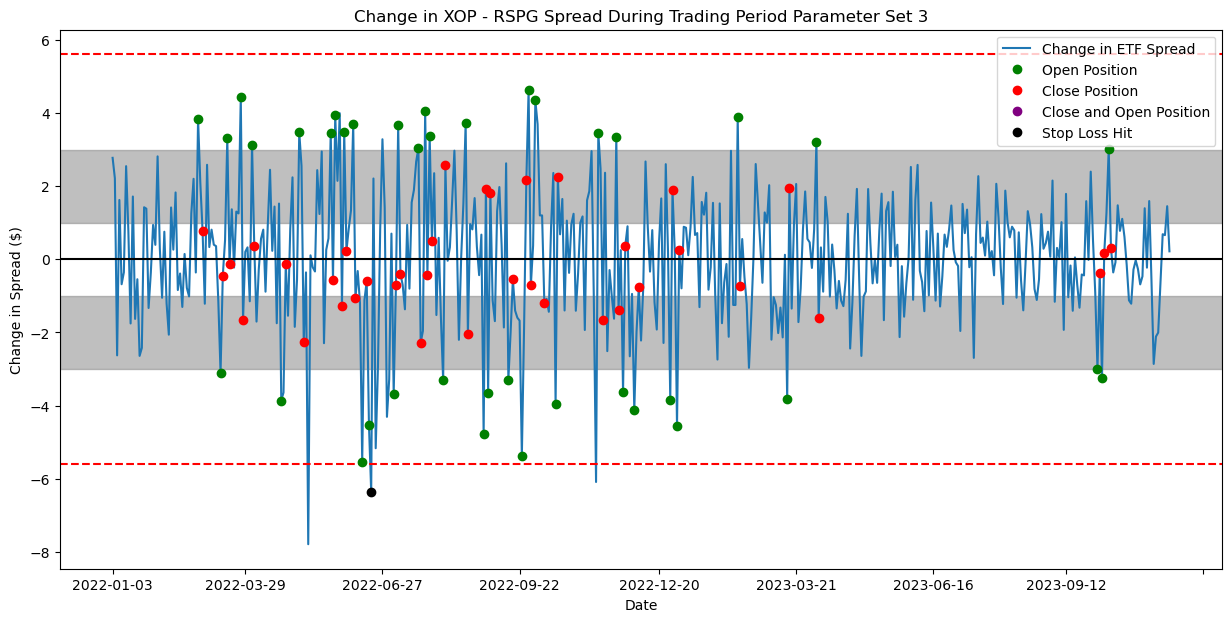

In [994]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df[['Change in Spread']].loc['2022':], label='Change in ETF Spread')
plt.title('Change in XOP - RSPG Spread During Trading Period Parameter Set 3')
plt.xlabel('Date')
plt.ylabel('Change in Spread ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
# add a black horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-')
# add a red dotted horizontal line for the stop loss
plt.axhline(y=abs_stop_loss, color='red', linestyle='--')
plt.axhline(y=-abs_stop_loss, color='red', linestyle='--')
# add a shaded region between y = .5 and y = 2
plt.axhspan(trade_signals_3['Close Short'], trade_signals_3['Open Short'], alpha=0.5, color='grey')
plt.axhspan(trade_signals_3['Close Long'], trade_signals_3['Open Long'], alpha=0.5, color='grey')

plt.plot(trade_df_3['Change in Spread'].loc[trade_df_3['Day Trade Action'] == 'open'], color='green', marker='o', linestyle = 'none', label='Open Position')
plt.plot(trade_df_3['Change in Spread'].loc[trade_df_3['Day Trade Action'] == 'close'], color='red', marker='o', linestyle = 'none', label='Close Position')
plt.plot(trade_df_3['Change in Spread'].loc[trade_df_3['Day Trade Action'] == 'close and open'], color='purple', marker='o', linestyle = 'none', label='Close and Open Position')
plt.plot(trade_df_3['Change in Spread'].loc[trade_df_3['Day Trade Action'] == 'stop loss hit'], color='black', marker='o', linestyle = 'none', label='Stop Loss Hit')

plt.legend()
plt.show()

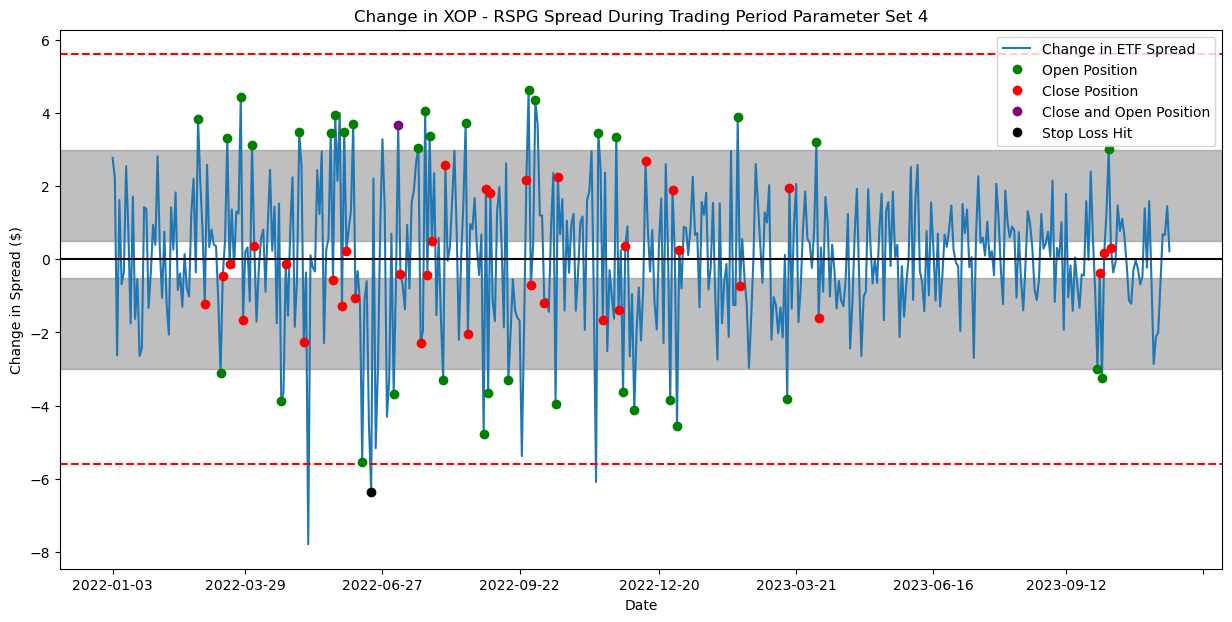

In [995]:
plt.figure(figsize=(15, 7))
plt.plot(trade_df[['Change in Spread']].loc['2022':], label='Change in ETF Spread')
plt.title('Change in XOP - RSPG Spread During Trading Period Parameter Set 4')
plt.xlabel('Date')
plt.ylabel('Change in Spread ($)')
# change the x axis to display every other month
plt.gca().xaxis.set_major_locator(dates.MonthLocator(interval=2))
# add a black horizontal line at 0
plt.axhline(y=0, color='black', linestyle='-')
# add a red dotted horizontal line for the stop loss
plt.axhline(y=abs_stop_loss, color='red', linestyle='--')
plt.axhline(y=-abs_stop_loss, color='red', linestyle='--')
# add a shaded region between y = .5 and y = 2
plt.axhspan(trade_signals_4['Close Short'], trade_signals_4['Open Short'], alpha=0.5, color='grey')
plt.axhspan(trade_signals_4['Close Long'], trade_signals_4['Open Long'], alpha=0.5, color='grey')

plt.plot(trade_df_4['Change in Spread'].loc[trade_df_4['Day Trade Action'] == 'open'], color='green', marker='o', linestyle = 'none', label='Open Position')
plt.plot(trade_df_4['Change in Spread'].loc[trade_df_4['Day Trade Action'] == 'close'], color='red', marker='o', linestyle = 'none', label='Close Position')
plt.plot(trade_df_4['Change in Spread'].loc[trade_df_4['Day Trade Action'] == 'close and open'], color='purple', marker='o', linestyle = 'none', label='Close and Open Position')
plt.plot(trade_df_4['Change in Spread'].loc[trade_df_4['Day Trade Action'] == 'stop loss hit'], color='black', marker='o', linestyle = 'none', label='Stop Loss Hit')

plt.legend()
plt.show()

# Analysis

For the analysis I will be moving forward with the parameter set 1, 2, and 4 results as they performed the best over the time horizon.

In [996]:
trade_df_2.index = pd.to_datetime(trade_df_2.index)
trade_df_4.index = pd.to_datetime(trade_df_4.index)
trade_df_1.index = pd.to_datetime(trade_df_1.index)
svol_df.index = pd.to_datetime(svol_df.index)

In [997]:
ff_factors['Strategy Parameter 1 Returns'] = trade_df_1.loc[:, 'Total Capital (Costless)'].pct_change()
ff_factors['Strategy Parameter 2 Returns'] = trade_df_2.loc[:, 'Total Capital (Costless)'].pct_change()
ff_factors['Strategy Parameter 4 Returns'] = trade_df_4.loc[:, 'Total Capital (Costless)'].pct_change()
ff_factors['SVol'] = svol_df['adj_close'].pct_change()

In [998]:
return_df = ff_factors.loc['2022-01-04':, ['Strategy Parameter 1 Returns', 'Strategy Parameter 2 Returns', 'Strategy Parameter 4 Returns', 'SVol', 'Mkt-RF', 'SMB', 'HML']]

<Axes: >

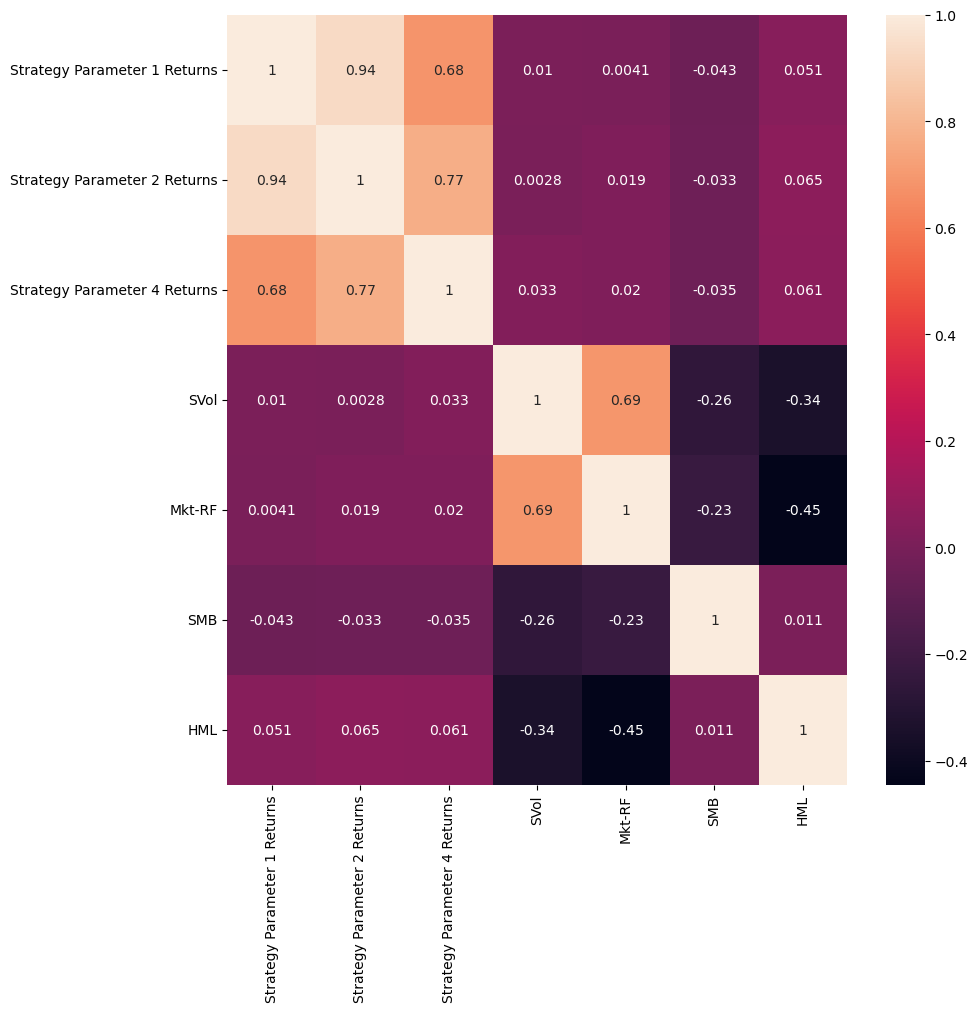

In [999]:
fig, ax = plt.subplots(figsize=(10,10))
correlation_matrix = return_df.corr()
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns, annot=True)

In [1000]:
def summary_statistics_annualized(returns, annual_factor = 252):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()
    
    return summary_statistics

In [1001]:
summary_statistics_annualized(return_df[['Strategy Parameter 1 Returns', 'Strategy Parameter 2 Returns', 'Strategy Parameter 4 Returns', 'SVol', 'Mkt-RF', 'SMB', 'HML']])

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
Strategy Parameter 1 Returns,0.000029,0.000132,0.221901,-0.000064,0.000044,-2.478741,24.411541,-4.076402e-06,-0.000022
Strategy Parameter 2 Returns,0.000072,0.000139,0.522581,-0.000056,0.000048,-1.472271,19.533477,-4.837035e-06,-0.000023
Strategy Parameter 4 Returns,0.000070,0.000106,0.659297,-0.000056,0.000048,-1.388541,36.895410,-5.396132e-07,-0.000013
SVol,-0.027559,0.150224,-0.183451,-0.036507,0.027254,-0.862111,2.002386,-1.759203e-02,-0.025770
Mkt-RF,-4.672608,17.268884,-0.270580,-3.670000,5.030000,0.145205,1.355519,-1.670000e+00,-2.348846
SMB,-9.733306,6.664305,-1.460513,-1.370000,1.700000,0.183930,0.592986,-6.700000e-01,-0.857407
HML,11.885914,11.378423,1.044601,-2.510000,2.480000,-0.278589,1.033477,-1.161000e+00,-1.638000


# Conclusion

Overall, the trading strategy on the spread between XOP and RSPG did not have very much correlation with the fama french factors or the SVol return. For the parameter sets I analyzed the first month of daily spread changes and chose different entry and exit positions that seemed to best capture the mean reverting property of daily spread change. For the first set I chose to enter and exit a short position on the spread when the change was above and below 2 and 1 respectively and enter and exit a long position when the change was less than and greater than -2 and -1 respectively. For the second set I chose 2 and .5 and -2 and -.5 for the short and long position. For the third set I chose 3 and 1 and -3 and -1 for the short and long position. and FInally for the 4th set I chose 3 and .5 and -3 and -.5 for the short and long position. I varied the parameters in this way to test the effects of changing only the entry or exit parameters for the postion. Of the Parameter sets the 2nd set, which had the lowest absolute entry and exit positions on the spread, had the best performance. This may be because since the daily change in spread is so likely to zero revert that having a lower barrier of entry to open a position and a stricter barrier to exit the position ensured that the higher gains of the short or long position are locked in. FOr the summary statistics the strategy with the 4th set of parameters had the best sharpe ratio with the strategy that had the 2nd set of parameters coming in a close second. As they had very similar mean returns this advantage seems to mostly stem from the increase in volatility for the 2nd set of parameters which makes sense because there is a lower barrier of entry for the positions and it is harder to close out these positions with the lower parameters. This is further shown when looking at the cumulative profit and loss because while the second set of parameters ended with the highest profit it took a deeper dive around June of 2022 when all of the strategies performed the worst. In the future it would be interesting to implement an algorithm to optimize the parameters or to create parameters that dynamically updated but for this optimization there would need to be in and out of sample data to first selesct the parameters and then to test their performance. FOr dynamically updating parameters there would have to be much thought put in from a risk management point of view to avoid overfitting and getting crushed if the strategy deviated from expectation.